#### Q4

If we set $b_j = u_j v_j$ for all $j = 1, 2, \cdots, p$, keep all of these weights $\in \mathbb{R}$, and fix the above products for all $j$, to minimize the $2^{\text{nd}}$ problem in this question: \begin{equation}
    \min_{\{u_j\}, \{v_j\}} \sum_{i=1}^n \left[y_i - \sum_{j=1}^p x_j (u_j v_j \equiv b_j)\right]^2 + \lambda \sum_{j=1}^p ((u_j)^2 + (v_j)^2) %= \min_{\{u_j\}, \{v_j\}} \sum_{i=1}^n \left[y_i - \sum_{j=1}^p x_j b_j\right]^2 + \lambda \sum_{j=1}^p ((u_j)^2 + (v_j)^2)
\end{equation} can be equivalent to \begin{equation}
    \label{eq:min_uv}
    \min_{u_j, v_j} \text{ } (u_j)^2 + (v_j)^2 \text{ subject to } u_j v_j = b_j \Leftrightarrow \min_{u_j, v_j} \text{ } (u_j)^2 + (v_j)^2 + \gamma (u_j v_j - \beta_j) \quad \forall \text{ } j.
\end{equation} Solving Eq. \ref{eq:min_uv} gives ($\gamma = 2\text{sgn}(b_j)$,) $u_j = \pm \sqrt{|b_j|}$ and $v_j = \text{sgn}(b_j) u_j$. Then plugging this back to the original problem gives \begin{equation}
    \min_{\{u_j\}, \{v_j\}} \sum_{i=1}^n \left[y_i - \sum_{j=1}^p x_j b_j\right]^2 + 2 \lambda \sum_{j=1}^p |b_j| = \min_{\{u_j\}, \{v_j\}} \dfrac{1}{2} \sum_{i=1}^n \left[y_i - \sum_{j=1}^p x_j b_j\right]^2 + \lambda \sum_{j=1}^p |b_j|,
\end{equation} which should reduce to the $1^{\text{st}}$ Lasso problem. \\

Then to verify the above deduction, here are the codes trying to solve both problems given the synthetic model $Y = XB + E (n = 100, p = 5)$. I need to implement a multivariate minimizer with help of scipy to solve the $2^{\text{nd}}$ problem, while the \texttt{lasso\_path} from \texttt{sklearn} is used to get the solution path for the $1^{\text{st}}$ problem.

In [1]:
import os
import sys
import time
import warnings

from matplotlib import pyplot as plt
from numpy import (array, where, empty, mean, log, pi, zeros, ones,
                   sqrt, eye, set_printoptions, prod, delete,
                   logspace, log10, trace, dot, flip, sign, arange)
from numpy.linalg import pinv
from numpy.random import default_rng, normal, multivariate_normal
from scipy.optimize import minimize, show_options
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import lasso_path
from sklearn.utils._testing import ignore_warnings

%matplotlib inline

# Display preparations

set_printoptions(suppress=True)
a_font = {'fontname': 'Arial', 'fontsize': 12}
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
start = time.perf_counter()

# The same data set used in Q1 and Q4

n, p, q = 1000, 5, 1
sigma_b, sigma_e = 2, 3     # so var_b = 4, var_e = 9
rnge = default_rng(777)
E, S, Z1 = rnge.normal(0, sigma_e, n), eye(p*q), empty((n,))
Z1 = E.copy()

rngx, rngb = default_rng(42), default_rng(69)
# originally it was X_1 B_1 + ... + X_p B_p
# each B_i is q*1, each X_i is n*q
# now merge all the X_i and B_i together
X1 = rngx.multivariate_normal(zeros((p*q,)), S, n)
B1 = rngb.normal(0, sigma_b, p*q)
Z1 += X1 @ B1

sigma_u = 2.5
rngu = default_rng(81)
U4 = rngu.normal(0, sigma_u, p*q)
V4 = B1 / U4
X4, B4, Z4 = X1.copy(), B1.copy(), Z1.copy()

In [3]:
# The domain of the solution paths that depends on lambda

lasso_a = logspace(-3, 2, 21)

# The legendary lasso_path from sklearn

a_lasso, c_lasso, _ = lasso_path(
    X4, Z4, alphas=lasso_a, tol=(10 ** -4), max_iter=1000)

In [4]:
res_u, res_v, res_bs = [], [], []

# the manual multivariate minimizer that sklearn doesn't have

for a in lasso_a:
    
    # the main dish -- minimize on both U and V
    # the initial values for U then V is in the 10-tuple

    fun_uv = lambda b: sum([z ** 2 for z in Z4 - X4 @ array(
        [b[0] * b[5], b[1] * b[6], b[2] * b[7], b[3] * b[8],
         b[4] * b[9]])]) / n + a * sum([bi ** 2 for bi in b])
    cons_uv = ({'type': 'eq', 'fun': lambda b: B4 - array([
        b[0] * b[5], b[1] * b[6], b[2] * b[7], b[3] * b[8], b[4] * b[9]])})
    res_uv = minimize(fun_uv, (1, 1, 1, 1, 1, 1, 1, 1, -1, -1),
                      constraints=cons_uv, method='Nelder-Mead',
                      options={"maxiter": 10000, 'xatol': 10 ** -15})
    
    # the sanity check -- only minimize on B
    # the initial values for B is in the 5-tuple

    fun_b = lambda b: sum([z ** 2 for z in Z4 - X4 @ array([
        bi for bi in b])]) / (2 * n) + a * sum([abs(bi) for bi in b])
    cons_b = ({'type': 'eq', 'fun': lambda b: array(
        [b[0], b[1], b[2], b[3], b[4]]) - B4})
    res_b = minimize(fun_b, (1, 1, 1, -1, -1),
                     constraints=cons_b, method='Nelder-Mead',
                     options={"maxiter": 2000, 'xatol': 10 ** -15})

    res_u.append(list(res_uv['x'][:5]))
    res_v.append(list(res_uv['x'][5:]))
    res_bs.append(list(res_b['x']))

This part takes 121.31 seconds!


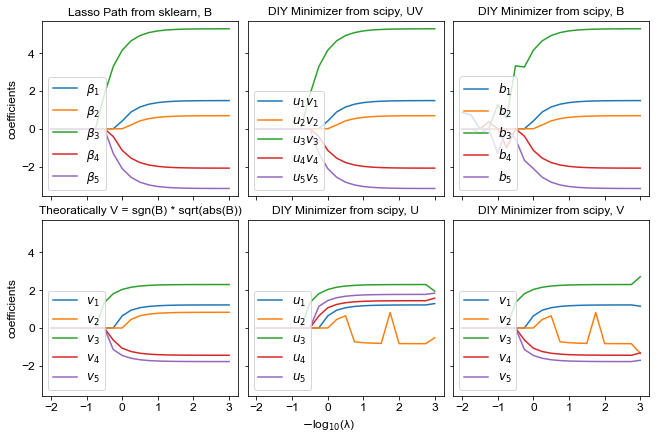

In [5]:
figa, [[axea, axeb, axec], [axed, axee, axef]] = plt.subplots(
    figsize=(9, 6), ncols=3, nrows=2,
    sharex=True, sharey=True, constrained_layout=True)

neg_log_a_lasso = -log10(a_lasso)
coef_ls = c_lasso.tolist()

# axea: plot the solution path from lasso_path
# axeb: then plot the theoretical solution path if we split b_j = u_j v_j
# which for convenience we set u_j = sqrt(abs(b_j)),
# v_j = sgn(b_j) * sqrt(abs(b_j)) respectively

for coef_l in coef_ls:
    axea.plot(neg_log_a_lasso, coef_l, label=r"$\beta_{{{}}}$".format(
        1 + coef_ls.index(coef_l)))
    axed.plot(neg_log_a_lasso, [sign(b) * sqrt(abs(b)) for b in coef_l],
              label=r"$v_{{{}}}$".format(1 + coef_ls.index(coef_l)))
    
for ax in [axea, axed]:
    ax.set_ylabel("coefficients", **a_font)

axea.set_title("Lasso Path from sklearn, B", **a_font)
axed.set_title("Theoratically V = sgn(B) * sqrt(abs(B))", **a_font)

# flip the coefficients before plotting

coef_us = list(map(list, zip(*flip(res_u))))[::-1]
coef_vs = list(map(list, zip(*flip(res_v))))[::-1]
coef_bs = list(map(list, zip(*flip(res_bs))))[::-1]

# plot the coefficients
# axeb: tilde(b_j) = hat(u_j) * hat(v_j)
# axec: another b_j approximates as sanity check
# axee: hat(u_j)
# axef: hat(v_j)

for (coef_u, coef_v, coef_b) in zip(coef_us, coef_vs, coef_bs):

    axeb.plot(neg_log_a_lasso, [u * v for u, v in zip(coef_u, coef_v)],
              label=r"$u_{{{}}}v_{{{}}}$".format(
                  1 + coef_us.index(coef_u), 1 + coef_vs.index(coef_v)))
    axec.plot(neg_log_a_lasso, coef_b, label=r"$b_{{{}}}$".format(
        1 + coef_bs.index(coef_b)))
    axee.plot(neg_log_a_lasso, coef_u, label=r"$u_{{{}}}$".format(
        1 + coef_us.index(coef_u)))
    axef.plot(neg_log_a_lasso, coef_v, label=r"$v_{{{}}}$".format(
        1 + coef_vs.index(coef_v)))
    
axeb.set_title("DIY Minimizer from scipy, UV", **a_font)
axec.set_title("DIY Minimizer from scipy, B", **a_font)
axee.set_title("DIY Minimizer from scipy, U", **a_font)
axef.set_title("DIY Minimizer from scipy, V", **a_font)

for ax in [axea, axeb, axec, axed, axee, axef]:
    ax.legend(loc="lower left")

figa.supxlabel(r"$-$log${}_{10}$(λ)", **a_font)
axea.set_xticks(arange(min(neg_log_a_lasso), max(neg_log_a_lasso)+1, 1.0))

end = time.perf_counter()
print("This part takes {:.2f} seconds!".format(end - start))

The main characters are the subplots titled ''Lasso Path from ``sklearn``, B'' ($\hat{B}(\lambda)$) and ''DIY Minimizer from ``scipy``, UV'' ($\tilde{B}(\lambda)$). The subplot ''DIY Minimizer from ``scipy``, B'' is simply a sanity check about the functionality of the minimizer. By comparing the solution path $\hat{B}(\lambda)$ and $\tilde{B}(\lambda) = \hat{U}(\lambda) \cdot \hat{V}(\lambda)$, we could somehow show the deduction is right but we also find out the $2^{\text{nd}}$ problem is actually not convex in two ways.

- The jumps of $u_2$ and $v_2$ along the $\lambda$ (which ``sklearn`` uses $\alpha$ to denote) values are obvious compared to the ''theoretical V'' plot deduced from the paths of $\hat{B}(\lambda)$ by forcing the ''theoretical U'' to be non-negative. Anyway, all the $b_j$ coefficients given all the 21 $\lambda$ values tested \textbf{all converges} to the values found by ``lasso_path`` from ``sklearn`` is good enough for us to claim $\hat{B}(\lambda) = \tilde{B}(\lambda)$ despite the oscillations of $u_j$ and $v_j$;

- The initial values for $\hat{U}(\lambda)$ and $\hat{V}(\lambda)$ that generated the above solution plots are $[1, 1, 1, 1, 1]$ and $[1, 1, 1, -1, -1]$ respectively. Changing the initial values, for example back to all $0$ like the default option in ``sklearn``'s ``lasso_path``, could give very different solution paths: $\Box$

In [6]:
# redo the minimizer with new initial values

res_u, res_v, res_bs = [], [], []

# the manual multivariate minimizer that sklearn doesn't have

for a in lasso_a:
    
    # the main dish -- minimize on both U and V
    # the initial values for U then V is in the 10-tuple

    fun_uv = lambda b: sum([z ** 2 for z in Z4 - X4 @ array(
        [b[0] * b[5], b[1] * b[6], b[2] * b[7], b[3] * b[8],
         b[4] * b[9]])]) / n + a * sum([bi ** 2 for bi in b])
    cons_uv = ({'type': 'eq', 'fun': lambda b: B4 - array([
        b[0] * b[5], b[1] * b[6], b[2] * b[7], b[3] * b[8], b[4] * b[9]])})
    res_uv = minimize(fun_uv, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                      constraints=cons_uv, method='Nelder-Mead',
                      options={"maxiter": 10000, 'xatol': 10 ** -15})

    res_u.append(list(res_uv['x'][:5]))
    res_v.append(list(res_uv['x'][5:]))

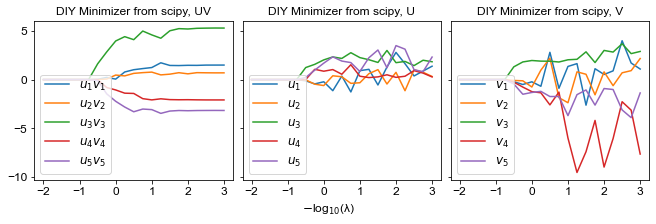

In [7]:
coef_us = list(map(list, zip(*flip(res_u))))[::-1]
coef_vs = list(map(list, zip(*flip(res_v))))[::-1]

figg, [axeg, axeh, axei] = plt.subplots(figsize=(9, 3), ncols=3, nrows=1,
    sharex=True, sharey=True, constrained_layout=True)

# plot the coefficients
# axeb: tilde(b_j) = hat(u_j) * hat(v_j)
# axec: another b_j approximates as sanity check
# axee: hat(u_j)
# axef: hat(v_j)

for (coef_u, coef_v) in zip(coef_us, coef_vs):

    axeg.plot(neg_log_a_lasso, [u * v for u, v in zip(coef_u, coef_v)],
              label=r"$u_{{{}}}v_{{{}}}$".format(
                  1 + coef_us.index(coef_u), 1 + coef_vs.index(coef_v)))
    axeh.plot(neg_log_a_lasso, coef_u, label=r"$u_{{{}}}$".format(
        1 + coef_us.index(coef_u)))
    axei.plot(neg_log_a_lasso, coef_v, label=r"$v_{{{}}}$".format(
        1 + coef_vs.index(coef_v)))
    
axeg.set_title("DIY Minimizer from scipy, UV", **a_font)
axeh.set_title("DIY Minimizer from scipy, U", **a_font)
axei.set_title("DIY Minimizer from scipy, V", **a_font)

for ax in [axeg, axeh, axei]:
    ax.legend(loc="lower left")
    
figg.supxlabel(r"$-$log${}_{10}$(λ)", **a_font)
axeg.set_xticks(arange(min(neg_log_a_lasso), max(neg_log_a_lasso)+1, 1.0))

#### Q1

Now that the model is \begin{equation}
    \underset{n \times 1}{Y} = \sum_{j = 1}^p \underset{n \times 1}{X_j} b_j + E = \left(\underset{n \times p}{X}\right) \quad \left(\underset{p \times 1}{B}\right) + E, 
\end{equation} where $B = [b_1, b_2, \cdots, b_p]^T, p(B) = N(B|0, (\sigma_b)^2 I_{p \times p})$ and $X = [X_1 | X_2 | \cdots | X_p] = [x_1, x_2, \cdots x_n]^T$, which $x_k = [x_{k,1}, x_{k,2}, \cdots, x_{k,p}]$ for $k = 1$ to $n$.

For the standard EM algorithm, we can derive the exact posterior of $B$: \begin{equation}
    \begin{split}
        B | Y, X, (\sigma_e)^2, (\sigma_b)^2 &\sim N(B | M_b, S_b), \text{ where } S_b = \left[\dfrac{1}{(\sigma_b)^2} I_{p \times p} + \dfrac{1}{(\sigma_e)^2} X^T X\right]^{-1}, \\ M_b &= \left[\dfrac{(\sigma_e)^2}{(\sigma_b)^2} I_{p \times p} + X^T X\right]^{-1} X^T Y = (\sigma_e)^2 S_b X^T Y, 
    \end{split}
\end{equation} so that the estimates of $(\sigma_e)^2$ and $(\sigma_b)^2$ would be \begin{equation}
    \begin{split}
        (\sigma_e)^2 = ((M_b)^T M_b + \text{Tr}(S_b))/p, (\sigma_b)^2 = ((\lVert Y - XM_b\rVert_2)^2 + \text{Tr}(X^T X S_b))/n.
    \end{split}
\end{equation}

In [8]:
# Standard EM


def STEM(Y, X, s_b, s_e):

    global n, p, q
    lLs_st, inlLs_st = [], []
    varb_old, vare_old = s_b, s_e

    while True:

        print("The existing parameters:")
        for values in [varb_old, vare_old]:
            print(round(values, 6), end=" ")
        print("")

        Mb = pinv((vare_old / varb_old) * eye(p * q) + X.T @ X) @ X.T @ Y
        Sb = pinv(varb_old ** -1 * eye(p * q) + vare_old ** -1 * X.T @ X)

        # the incomplete log likelihood
        # ln p(Y | B, var_e)

        E_error = (Y - X @ Mb).T @ (Y - X @ Mb) + trace(X.T @ X @ Sb)
        inc_ll_old = -(n * log(2 * pi * vare_old) + E_error / vare_old) / 2
        inlLs_st.append(inc_ll_old)

        # parameter update

        varb_new, vare_new = (Mb.T @ Mb + trace(Sb)) / (p * q), E_error / n
        inc_ll_new = -(n * log(2 * pi * vare_new) + E_error / vare_new) / 2

        # refresh

        varb_old, vare_old = varb_new, vare_new

        print("Incomplete log-likelihood difference")
        print(inc_ll_new - inc_ll_old)

        if inc_ll_new - inc_ll_old < 10 ** -6:
            inlLs_st.append(inc_ll_new)
            print("Incomplete log-likelihood looks converged!")
            print("Final EMed parameters: var_b & var_e")
            for values in [varb_new, vare_new]:
                print(round(values, 6), end=" ")
            print("\nThe EMed mean of B:")
            print(pinv((vare_new / varb_new) * eye(p * q) + X.T @ X) @ X.T @ Y)
            break

    print("Standard EM done!")
    return inlLs_st

The existing parameters:
1 1 
Incomplete log-likelihood difference
3039.0410136310165
The existing parameters:
9.002729 9.309071 
Incomplete log-likelihood difference
0.004955024411174236
The existing parameters:
9.010434 9.350577 
Incomplete log-likelihood difference
1.2312011676840484e-07
Incomplete log-likelihood looks converged!
Final EMed parameters: var_b & var_e
9.010404 9.350784 
The EMed mean of B:
[ 1.4904902   0.69204097  5.28893648 -2.08423619 -3.16031454]
Standard EM done!


Text(0.5, 1.0, 'Incomplete log-likelihood')

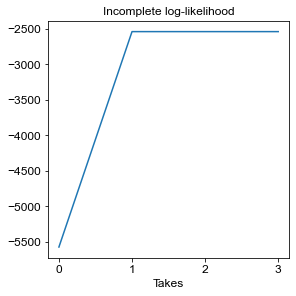

In [9]:
inlLs_out = STEM(Z1, X1, s_b=1, s_e=1)

figj, axej = plt.subplots(figsize=(4, 4), constrained_layout=True)
axej.plot(inlLs_out)
axej.set_xlabel("Takes", **a_font)
axej.set_title("Incomplete log-likelihood", **a_font)

Then the mean-field approximation of $\ln( (q_j)^*(b_j))$ for each $j$ from $1$ to $p$ asks for $E_{i \neq j} (\ln p(Y, B))$ \begin{equation}
    \begin{split}
        = &-\dfrac{1}{2(\sigma_b)^2} E_{i \neq j} (B^T B) - \dfrac{1}{2(\sigma_e)^2} \sum_{k} E_{i \neq j} [(y_k - x_{k,j} b_j - \sum_{i \neq j} x_{k,i} b_i)^2] \\
        &- \dfrac{n}{2} \ln (2\pi(\sigma_e)^2) - \dfrac{p}{2}\ln(2\pi(\sigma_b)^2).
    \end{split}
\end{equation}

$E_{i \neq j}(B^T B)$ gives \begin{equation}
    (M_{b, i \neq j})^T M_{b, i \neq j} + S_{b, i \neq j},
\end{equation} which $M_{b, i \neq j} = [m_1, m_2, \cdots, m_{j-1}, b_j, m_{j+1}, \cdots, m_p]$ and $S_{b, i \neq j}$ should store the covariances between all the $b_{i \neq j}$ (size $(p - 1) \times (p - 1)$) plus the all 0 row $j$ and column $j$ to form the $p \times p$ covariance matrix, and $E_{i \neq j}[(y_k - x_{k, j} b_j - \sum_{i \neq j} x_{k, i} b_i)^2]$ \begin{equation}
    \begin{split}
        &= (y_k)^2 - 2y_k E_{i \neq j}(B^T) x_{k} + \text{Trace}(x_{k}(x_{k})^T E_{i \neq j} (BB^T)) \\
        &= (y_k)^2 - 2y_k M_{b, i \neq j} x_k + \text{Trace}(x_k (x_k)^T (M_{b, i \neq j} (M_{b, i \neq j})^T + S_{b, i \neq j})).
    \end{split}
\end{equation}

So that the estimates of $(\sigma_b)^2$ and $(\sigma_e)^2$ under this approximation would be \begin{equation}
    \begin{split}
        (\sigma_e)^2 &= ((M_{b, i \neq j})^T M_{b, i \neq j} + \text{Tr}(S_{b, i \neq j}))/p \text{ } \forall \text{ } j = 1, 2, \cdots, p \\
        &= \left((M_{b, i \neq j})^T M_{b, i \neq j} + \prod_{i \neq j} (\sigma_i)^2\right)/p = \left(\sum_{j} (M_{b, i \neq j})^T M_{b, i \neq j} + \prod_{i \neq j} (\sigma_i)^2\right) \div (p^2) \\
        &= \left((p-1) \sum_j (m_j)^2 + p\prod_j (\sigma_j)^2 \div \left(\sum_j (\sigma_j)^2
        \right)\right) \div (p^2), \\
        (\sigma_b)^2 &= \left[(\lVert Y - X M_{b, i \neq j} \rVert_2)^2 + \text{Tr}(X^T X S_{b, i \neq j})\right] / n \text{ } \forall \text{ } j = 1, 2, \cdots, p.
    \end{split}
\end{equation} And eventually the posterior mean $M_{b, mf} = [u_1, u_2, \cdots, u_p]$ and variance $S_{b, mf}$ under the mean-field approximation would be \begin{equation}
    \begin{split}
        (q_j)^* (b_j) &= N(b_j | m_k, s_k), \text{ where} \\
        s_j &= 1 \div ((\sigma_b)^{-2} + (\sigma_e)^{-2} (x_j)^T x_j), \\
        m_j &= \left[\dfrac{(\sigma_e)^2}{(\sigma_b)^2} + (x_j)^T x_j \right]^{-1} (x_j)^T \left[Y - \sum_{i \neq j} m_i x_i\right]. \text{ } \Box
    \end{split}
\end{equation} 

#### Q2a

Now that $\displaystyle \sum_{i = 1}^K f_i(\boldsymbol{x}) = 0$, the conditional expectation of the loss function for each $\boldsymbol{y}$ can be evaluated as \begin{equation}
    \begin{split}
        E_{\boldsymbol{y}|\boldsymbol{x}} \left[L(\boldsymbol{y}, \boldsymbol{f}(\boldsymbol{x}))\right] &= \sum_{i = 1}^K \exp\left[-\left(f_i(\boldsymbol{x}) - \sum_{h \neq i}\dfrac{1}{K-1} f_h(\boldsymbol{x})\right) \div K\right] P(c = i | \boldsymbol{x}) \\
        &= \sum_{i = 1}^K \exp\left[- \left(\dfrac{Kf_i(\boldsymbol{x})}{K-1} \right) \div K\right] P(c = i | \boldsymbol{x})  = \sum_{i = 1}^K \exp\left[-\dfrac{f_i(\boldsymbol{x})}{K-1}\right] P(c = i | \boldsymbol{x}).
    \end{split}
\end{equation}

Then the Lagrangian function of the problem can be written as \begin{equation}
    G(\boldsymbol{x}, \boldsymbol{f}, \lambda) = \sum_{i = 1}^K \exp\left[-\dfrac{f_i(\boldsymbol{x})}{K-1}\right] P(c = i | \boldsymbol{x}) - \lambda\left(\sum_{j=1}^K f_j(\boldsymbol{x}) - 0\right).
\end{equation}

Set $\displaystyle \dfrac{\partial G}{\partial f_j(\boldsymbol{x})} = 0$ for $j = 1, 2, \cdots, K$ gives $0 = -\dfrac{P(c = j | \boldsymbol{x})}{K - 1}\exp\left[-\dfrac{f_j(\boldsymbol{x})}{K-1}\right] - \lambda$. Solving all these equations with $\displaystyle \sum_{i = 1}^K f_i(\boldsymbol{x}) = 0$ gives the population minimizer \begin{equation}
    \begin{split}
        (f_j)^*(\boldsymbol{x}) &= (K - 1)\left[\ln P(c = j | \boldsymbol{x}) - \dfrac{1}{K} \sum_{g = 1}^K \ln P(c = g | \boldsymbol{x})\right], \quad j = 1, 2, \cdots, K. \\
        \Rightarrow \text{arg}\underset{k}{\max} \text{ } (f_k)^*(\boldsymbol{x}) &= \text{arg}\underset{k}{\max} \text{ } P(c = k | \boldsymbol{x}).
    \end{split}
\end{equation} The population minimizer also gives a way to recover the class probability $P(c = k | \boldsymbol{x})$ from the estimates of $(f_k)^*(\boldsymbol{x})$ that \begin{equation}
    P(c = k | \boldsymbol{x}) = \exp\left[\dfrac{(f_k)^*(\boldsymbol{x})}{K-1}\right] \div \sum_{i = 1}^K \exp\left[\dfrac{(f_i)^*(\boldsymbol{x})}{K-1}\right], \quad k = 1, 2, \cdots, K. \text{ } \Box 
\end{equation}

#### Q2b

In this part we denote $\boldsymbol{f}_l = [f_{l,1}, f_{l,2}, \cdots, f_{l,K}]^T$ to be the $K$-dimensional population zero-sum function vector at $l^{\text{th}}$ iteration.

Also let

\begin{itemize}
\item $\boldsymbol{g}_l = [g_{1, l}, g_{2, l}, \cdots, g_{K, l}]: \mathbb{R}^K \to \mathbb{R}^K$ be the base classifiers in the $l^{\text{th}}$ iteration, that $l \in \mathbb{N}$ and $m = 1, 2, \cdots, M$,
\item $\boldsymbol{y}_{[m]}$ be a $K \times 1$ classification indication vector corresponding to the $m^{\text{th}}$ case s.t. $\boldsymbol{y}_{[m]} = \boldsymbol{y}_k$ if its class label $c = k$, which $k = 1, 2, \cdots, K$, and
\item $\boldsymbol{x}_{[m]}$ be the vector of explanatory variables in the $m^{\text{th}}$ case.
\end{itemize}

To start with the boosting algorithm, we initialize the weight $w_{m, 1} = 1/M$ for $m = 1, 2, \cdots, M$. Next for $l = 1, 2, \cdots, L$, we
\begin{itemize}
\item Fit a classifier $\boldsymbol{g}_l(\boldsymbol{x})$ to the training data by minimizing the weight error function \begin{equation}
    J_l = \left[\sum_{m=1}^M w_{m, l} \boldsymbol{Is}(c_m \neq \boldsymbol{g}_l(\boldsymbol{x}_{[m]}))\right] \div \sum_{m=1}^M w_{m, l}.
\end{equation}
\item Let $Y = [\{\boldsymbol{y}_{[m]}\}]^T$, a $M \times K$ matrix be the response and $X = [\{\boldsymbol{x}_{[m]}\}]^T$, also with $M$ rows be the design matrix. Then the exponential error function is \begin{equation}
    \hat{\mathbb{L}}(Y, \boldsymbol{f}_l(\boldsymbol{x}_{[1]}), \boldsymbol{f}_l(\boldsymbol{x}_{[2]}), \cdots, \boldsymbol{f}_l(\boldsymbol{x}_{[M]})) = \sum_{m=1}^M \exp\left[-\dfrac{(\boldsymbol{y}_{[m]})^T \boldsymbol{f}_l(\boldsymbol{x}_{[m]})}{K}\right].
\end{equation}
    \begin{itemize}
    \item By denoting with some $\alpha_l$ that \begin{equation}
    \boldsymbol{f}_l(\boldsymbol{x}_{[\cdots]})) = \boldsymbol{f}_{l-1}(\boldsymbol{x}_{[\cdots]})) + \alpha_l \boldsymbol{g}_l(\boldsymbol{x}_{[\cdots]})) \Rightarrow \boldsymbol{f}_p(\boldsymbol{x}_{[\cdots]})) = \sum_{l=1}^{p \leq L} \alpha_l \boldsymbol{g}_l(\boldsymbol{x}_{[\cdots]}),
\end{equation} we can rewrite the above error as \begin{equation}
    \hat{\mathbb{L}}(Y, \boldsymbol{f}_l(\boldsymbol{x}_{[1]}), \boldsymbol{f}_l(\boldsymbol{x}_{[2]}), \cdots, \boldsymbol{f}_l(\boldsymbol{x}_{[M]})) = \sum_{m=1}^M w_{m, l} \exp\left[-\dfrac{\alpha_l (\boldsymbol{y}_{[m]})^T \boldsymbol{g}_l(\boldsymbol{x}_{[m]})}{K}\right],
\end{equation} where $w_{m, l} = \exp\left[-(\boldsymbol{y}_{[m]})^T \boldsymbol{f}_{l-1}(\boldsymbol{x}_{[m]}) \div K \right]$.
    \item Note \begin{equation}
    (\boldsymbol{y}_{[m]})^T \boldsymbol{g}_p(\boldsymbol{x}_{[m]}) = \begin{cases} K/(K-1), &\text{if } \boldsymbol{y}_{[m]} = \boldsymbol{g}_p(\boldsymbol{x}_{[m]}), \\
    -K/(K-1)^2, &\text{if } \boldsymbol{y}_{[m]} \neq \boldsymbol{g}_p(\boldsymbol{x}_{[m]}).
    \end{cases}
\end{equation}
and $g_{k, l}(\boldsymbol{x}) = 1 \Rightarrow \boldsymbol{g}_l(\boldsymbol{x}) = k$.
    \end{itemize}
    \item Let $T_l$ and $F_l$ be the sets of correctly and incorrectly classified data points by $\boldsymbol{f}_l(\boldsymbol{x}_{[\cdots]})$ respectively in the $l^{\text{th}}$ iteration, then we can further rewrite the error into \begin{equation}
    \hat{\mathbb{L}}(Y, \boldsymbol{f}_l(\boldsymbol{x}_{[1]}), \boldsymbol{f}_l(\boldsymbol{x}_{[2]}), \cdots, \boldsymbol{f}_l(\boldsymbol{x}_{[M]})) = \exp\left[-\dfrac{\alpha_l}{K-1}\right] \sum_{i \in T_l} w_{i, l} + \exp\left[\dfrac{\alpha_l}{(K-1)^2}\right] \sum_{j \in F_l} w_{j, l}.
\end{equation}
    \begin{itemize}
    \item Set $\displaystyle \dfrac{\partial \hat{\mathbb{L}}}{\partial \alpha_l} = 0$ gives
    \begin{equation}
    \begin{split}
        0 &= -\dfrac{1}{K-1}\exp\left[-\dfrac{\alpha_l}{K-1}\right] \sum_{i \in T_l} w_{i, l} + \dfrac{1}{(K-1)^2}\exp\left[\dfrac{\alpha_l}{(K-1)^2}\right] \sum_{j \in F_l} w_{j, l} \\
        \Rightarrow (\alpha_l)^* &= \dfrac{(K-1)^2}{K} \left[\ln (K-1) + \ln \left(\dfrac{1 - \epsilon_l}{\epsilon_l}\right)\right] := \dfrac{(K-1)^2}{K} \beta_l, \\
        \text{where } \epsilon_l &:= \left(\sum_{m=1}^M w_{m, l} \boldsymbol{Is}(\boldsymbol{f}_l(\boldsymbol{x}_{[m]}) \neq \boldsymbol{y}_{[m]})\right) \div \sum_{m=1}^M w_{m, l}.
    \end{split}
    \end{equation}
    \end{itemize}
    \item To update $w_{m, l}$ we use the formula \begin{equation}
    w_{m, l+1} = w_{m, l} \exp\left[-\dfrac{(\alpha_l)^* (\boldsymbol{y}_{[m]})^T \boldsymbol{f}_l(\boldsymbol{x}_{[m]})}{K}\right] = \begin{cases} w_{m, l} \exp(-(K-1)\beta_l/K), & m \in T_l; \\ w_{m, l} \exp(\beta_l/K), & m \in F_l. \end{cases}
\end{equation}
    \item Then normalize $w_{m, l+1}$ by setting \begin{equation}
    w_{m, l+1} \leftarrow w_{m, l+1} \div \sum_{m=1}^M w_{m, l+1}.
\end{equation}
\end{itemize}

Finally the prediction after $L$ iterations is given by \begin{equation}
    \text{Pred}_L(\boldsymbol{x}) = \underset{k}{\text{argmax}} \left[\left(\sum_{l=1}^L (\alpha_l)^* \boldsymbol{f}_l(\boldsymbol{x})\right)^T\boldsymbol{e}_k\right],
\end{equation} where $\boldsymbol{e}_k$ is the $k^{\text{th}}$ standard basis of $\mathbb{R}^k$. Where the largest entry of the vector $\displaystyle \sum_{l=1}^L (\alpha_l)^* \boldsymbol{f}_l(\boldsymbol{x})$ is at in each sample gives the prediction to the class the sample belongs to.

The above algorithm has the new weight equivalent to the weight updating scheme in the Adaboost algorithm, while the $\beta_l$ in the above is defined as in the Adaboost algorithm but with the extra term $\ln (K-1)$. The difference simply disappears when $K = 2$ that $\ln (K-1) = \ln 1 = 0$. $\Box$

#### Q2c

So in this part, we use both the \begin{itemize}
\item multiclass boosting algorithm with classification trees (MB), and
\item graident boosting with multinomial regression (GB)
\end{itemize}  by calling the \texttt{DecisionTreeClassifier} and \texttt{GradientBoostingClassifer} from \texttt{\texttt{sklearn}} respectively to classify the samples in the Glass Identification Data Set ($n = M = 214$) with the responses in 7 classes (1 to 7) and the predictors that indicate the refractive index (RI) and the weight percent in corresponding oxide of 8 chemicals (sodium, magnesium, aluminium, silicon, potassium, calcium, barium, iron). 20 boosting iterations are done in each of the 10 repeats.

In [10]:
import os
import sys
import time
import warnings
from math import log
from matplotlib import pyplot as plt
from numpy import (linspace as lins, exp, array, where, zeros, ones, argmax,
                   set_printoptions, empty, full)
from pandas import read_csv, DataFrame as DF
from seaborn import pairplot, lineplot as slplot, set_context
from statistics import mean, stdev

from sklearn.ensemble import (GradientBoostingClassifier as GBC,
                              AdaBoostClassifier as ADBC)
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score, balanced_accuracy_score as bal_acc
from sklearn.model_selection import (train_test_split as TTS,
                                     GridSearchCV as GSCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler as SS, PowerTransformer as PT
from sklearn.tree import DecisionTreeClassifier as TC

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

set_printoptions(precision=3, suppress=True)

start = time.perf_counter()

# configs about the plots

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
a_font = {'fontname': 'Arial', 'fontsize': 12}

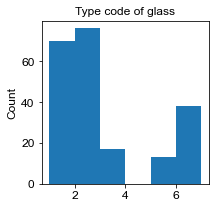

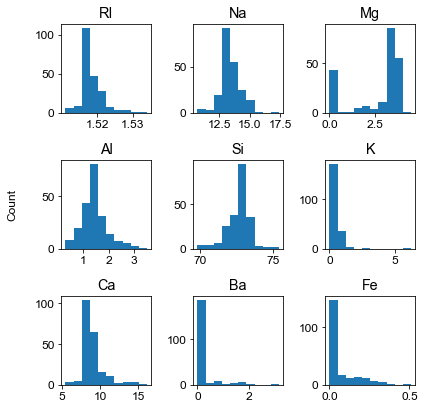

In [11]:
glass_df = read_csv('glass.csv', header=None)
glass_df.set_axis(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe',
                   'Type'], axis=1, inplace=True)

# visualize each column first by itself

figk, axek = plt.subplots(figsize=(3, 3))
glass_df['Type'].hist(grid=False, bins=[1, 2, 3, 4, 5, 6, 7], ax=axek)
axek.set_ylabel("Count", **a_font)
axek.set_title("Type code of glass", **a_font)

figl, axel = plt.subplots(ncols=3, nrows=3, figsize=(6, 5.85))
glass_df.iloc[:, :9].hist(grid=False, ax=axel)
figl.supylabel("Count", **a_font)

plt.tight_layout()

Note no glass smaple is in class 4, so we might expect no classifications to class 4 in this dataset. Since we observe quite skewed and even bimodal distributions from the predictors, we do the power transform and standardization in the following before feeding the data into the classifiers.

In [14]:
# retrieve numpy array
# split into input and output elements

glass_np = glass_df.values
X, Y = glass_np[:, :-1], glass_np[:, -1]

# sample size M = 214; the no. of classes K = 7

M, K = X.shape[0], int(max(Y))
class_iter = lins(1, K, K)

# max(iter_rs) = 10, max(iter_boost) = 20

iter_rs, iter_boost = lins(1, 10, 10), lins(1, 20, 20)
pipe_all = [Pipeline([('power', PT()), ('scaler', SS()), ('model', TC(
        random_state=int(i)))]) for i in iter_boost]

mbc_train_es, mbc_test_es, gbc_train_es, gbc_test_es = [], [], [], []

In [15]:
print("Iterations start!")

for h in iter_rs:

    X_train, X_test, Y_train, Y_test = TTS(
        X, Y, test_size=(64 / 214), random_state=int(h))

    train_e_mbc, test_e_mbc, train_e_gbc, test_e_gbc = [], [], [], []

    for l in iter_boost:

        # now l weak learners

        learners = pipe_all[:int(l)]
        M_train, M_test = int(X_train.shape[0]), int(X_test.shape[0])
        # N_learn = len(learner) = l

        # initialize the weights for each data entry

        w_sample_in = full((M_train,), fill_value=(1 / M_train))
        w_learn = zeros((int(l),))

        # sort the weak learners by error

        error = [0] * int(l)
        for id, learner in enumerate(learners):
            for (X_in, Y_in) in zip(X_train, Y_train):
                weak = learner.fit(X_train, Y_train)
                error[id] += int(int(weak.predict([X_in])[0]) != int(Y_in))

        sort_learners = [r for (r, e) in sorted(
            zip(learners, error), key=(lambda pair: pair[1]))]

        # boost

        for learn_id, learner in enumerate(sort_learners):
            
            # compute weighted error

            is_wrong = zeros((M_train,))
            stronger = learner.fit(X_train, Y_train)
            for X_id, X_in in enumerate(X_train):
                if int(stronger.predict([X_in])) != int(Y_train[X_id]):
                    is_wrong[X_id] = 1
            w_learner_e = sum(is_wrong * w_sample_in) / sum(w_sample_in)

            # compute alpha, if the learner is not qualified, set to 0
            # + 10 ** -8 to avoid numerical error

            w_learn[learn_id] = max(0.0, log(
                1 / (w_learner_e + 10 ** -8) - 1) + log(K - 1))
            alpha_arr = full((M_train,), fill_value=w_learn[learn_id])

            # update entry weights, prediction made by unqualified learner
            # will not update the entry weights

            w_sample_in *= exp(alpha_arr * is_wrong)
            w_sample_in = w_sample_in / sum(w_sample_in)

        # normalize the learner weights
        
        w_learn = w_learn / sum(w_learn)

        # really do the multiclass prediction

        mbc_pred_train, mbc_pred_test = [], []
        train_pools, train_pooled = zeros((M_train, K)), zeros((M_train, K))
        test_pools, test_pooled = zeros((M_test, K)), zeros((M_test, K))

        for idx, learner in enumerate(sort_learners):

            strongest = learner.fit(X_train, Y_train)

            for i in range(X_train.shape[0]):
                pred = [-1 / (K - 1)] * K
                pred[int(strongest.predict([X_train[i]])) - 1] = 1
                train_pooled[i, :] += array([w_learn[idx] * p for p in pred])

            train_pools += train_pooled

            for j in range(X_test.shape[0]):
                pred = [-1 / (K - 1)] * K
                pred[int(strongest.predict([X_test[j]])) - 1] = 1
                test_pooled[j, :] += array([w_learn[idx] * p for p in pred])

            test_pools += test_pooled

        for train_pool in train_pools:
            mbc_pred_train.append(argmax(train_pool) + 1)

        for test_pool in test_pools:
            mbc_pred_test.append(argmax(test_pool) + 1)

        mbc_train_score = sum([int(p == a) for (p, a) in zip(
            mbc_pred_train, Y_train)]) / M_train
        mbc_test_score = sum([int(p == a) for (p, a) in zip(
            mbc_pred_test, Y_test)]) / M_test

        train_mbc_e = (exp(-(K - 1) ** -1) * mbc_train_score +
                       exp((K - 1) ** -2) * (1 - mbc_train_score))
        test_mbc_e = (exp(-(K - 1) ** -1) * mbc_test_score +
                      exp((K - 1) ** -2) * (1 - mbc_test_score))

        train_e_mbc.append(train_mbc_e)
        test_e_mbc.append(test_mbc_e)

        # The standard gradient boosting by sklearn
        # after the power transform and standardization
        # on the distributions of those RI & chemical weights

        gbc = Pipeline([('power', PT()), ('scaler', SS()), ('model', GBC(
            random_state=0, n_estimators=int(l)))]).fit(X_train, Y_train)

        # gbc.score for GBC already counts the portion of correct classification
        # so no need divide the count by total sample size in the train/test sets

        train_gbc_e = (exp(-(K - 1) ** -1) * gbc.score(X_train, Y_train) +
                       exp((K - 1) ** -2) * (1 - gbc.score(X_train, Y_train)))
        test_gbc_e = (exp(-(K - 1) ** -1) * gbc.score(X_test, Y_test) +
                      exp((K - 1) ** -2) * (1 - gbc.score(X_test, Y_test)))

        train_e_gbc.append(train_gbc_e)
        test_e_gbc.append(test_gbc_e)

    print("Take {} done!".format(int(h)))

    mbc_train_es.append(train_e_mbc)
    mbc_test_es.append(test_e_mbc)
    gbc_train_es.append(train_e_gbc)
    gbc_test_es.append(test_e_gbc)

Iterations start!
Take 1 done!
Take 2 done!
Take 3 done!
Take 4 done!
Take 5 done!
Take 6 done!
Take 7 done!
Take 8 done!
Take 9 done!
Take 10 done!


In [16]:
def liststats(lists):

    for item in lists:
        out = array(item).transpose()
        out_mean, out_sd = [mean(s) for s in out], [stdev(s) for s in out]
        yield [out_mean, out_sd]

def setdfthenplot(y_mean, y_sd, axe):

    global iter_boost

    thedf = DF({"Boosting iterations": iter_boost, "Accuracy": y_mean})
    slplot(data=thedf.astype({'Boosting iterations': 'str'}),
           x=thedf["Boosting iterations"], y=thedf["Accuracy"], ax=axe)
    axe.fill_between(iter_boost, y1=[
        max(0, mu - sigma) for (mu, sigma) in zip(y_mean, y_sd)], y2=[
        mu + sigma for (mu, sigma) in zip(y_mean, y_sd)], alpha=.3)
    axe.set(xlabel=None, ylabel=None)

This part takes 12376.46 seconds!


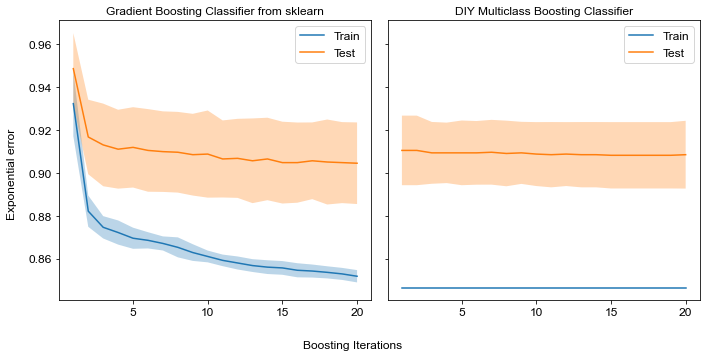

In [19]:
figm, [axem, axen] = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)

[mbc_train_mean, mbc_train_sd], [mbc_test_mean, mbc_test_sd], [
    gbc_train_mean, gbc_train_sd], [gbc_test_mean, gbc_test_sd] = liststats(
    [mbc_train_es, mbc_test_es, gbc_train_es, gbc_test_es])

setdfthenplot(gbc_train_mean, gbc_train_sd, axem)
setdfthenplot(gbc_test_mean, gbc_test_sd, axem)
setdfthenplot(mbc_train_mean, mbc_train_sd, axen)
setdfthenplot(mbc_test_mean, mbc_test_sd, axen)

for ax in [axem, axen]:
    ax.legend(handles=ax.lines[:], labels=["Train", "Test"])
axem.set_title("Gradient Boosting Classifier from sklearn", **a_font)
axen.set_title("DIY Multiclass Boosting Classifier", **a_font)

figm.supxlabel("Boosting Iterations", **a_font)
figm.supylabel("Exponential error", **a_font)

end = time.perf_counter()
print("This part takes {:.2f} seconds!".format(end - start))

plt.tight_layout()

The plots of the exponential errors show that \begin{itemize}
    \item The variances from the multiclass boosting classifier (MBC) is a bit smaller. \begin{itemize}
        \item The exponential training error of MBC simply goes to its lower bound while it still take iterations for that of GBC to approach.
        \item The exponential test error of MBC is on average a bit higher than that of GBC but is relatively stable than GBC along different iterations. $\Box$
    \end{itemize}
\end{itemize}

#### Q3a

Let's use English letters to replace the Greek letters in the model in this problem: \begin{equation}
    \begin{split}
        H_j &\sim N(H_j | G_j, (s_{G, j})^2), h_j \sim N(h_j | g_j, (s_{g, j})^2), \\
        g_j &\sim N(g_j | 0, (\sigma_g)^2), G_j = b g_j \text{ } \forall \text{ } j \text{ from } 1 \text{ to } 45.
    \end{split} 
\end{equation}

One way to estimate $G_j$ and $g_j$ from $H_j$ and $h_j$ is simply to take the maximum likelihood estimation, but this discard the info about $s_{G, j}$ and $s_{g, j}$ which is undesirable.

To consider $s_{g, j}$ at least, since the likelihood of $h_j$ and the prior of $g_j$ is given as \begin{equation}
    p(h_j | g_j) = N(h_j | g_j, (s_{g, j})^2), p(g_j) = N(g_j | 0, \sigma^2),
\end{equation}

The posterior of $g_j | h_j$ is \begin{equation}
    p(g_j | h_j) = N\left(g_j | \dfrac{\sigma^2}{(s_{g, j})^2 + \sigma^2} h_j, \dfrac{\sigma^2 (s_{g, j})^2}{(s_{g, j})^2 + \sigma^2}\right).
\end{equation} The problem is we are not given the value of $\sigma^2$, so we need to ''estimate'' it using the marginal distribution of $h_j$, that $p(h_j) = N(0, (s_{g, j})^2 + \sigma^2)$, and rely on \begin{equation}
    Q = \sum_{i = 1}^{45} (h_j)^2 / (\overline{(s_g)^2} + \sigma^2) \sim (\chi_{45})^2
\end{equation} with $\overline{(s_g)^2}$, the sample average of all the 45 $(s_{g, j})^2$ values. Then we may get $\tau^2$ the estimate of $\sigma^2$: \begin{equation}
    \tau^2 = \dfrac{\sum_{i=1}^{45} (h_i)^2}{45 - 2} - \overline{(s_g)^2}.
\end{equation} After that we again estimate $g_j$ by the mean of its posterior probability with $\tau^2$: $\dfrac{\tau^2}{(s_{g, j})^2 + \tau^2} h_j$. Meanwhile we don't really have an prior of $G_j$ without the helpe of $b$, so we might directly estimate $G_j$ by $H_j$ using the ML principle.

So after we find out the the estimates of $G_j$ and $g_j$, denoted $F_j$ and $f_j$, we find out the sampled values of $F_j/f_j$ denoted as $\beta_j$ $(j = 1, 2, \cdots, 45)$. Eventually we perform the 2-sided Student t-test with the null hypoethesis that $\beta = 0$.

In [20]:
from pandas import read_csv
from scipy.stats import ttest_1samp

data = read_csv('data_asm4.txt', sep="\t", header=None, skiprows=1)
data.columns = ["H", "h", "s_G", "s_g"]
data["var_G"] = data["s_G"] ** 2
data["var_g"] = data["s_g"] ** 2

H, h, var_G, var_g = data["H"], data["h"], data["var_G"], data["var_g"]
s_G, s_g = data["s_G"], data["s_g"]

tau_sq = sum([h_i ** 2 for h_i in h]) / (h.shape[0] - 2) - sum(
    [v for v in var_g]) / h.shape[0]

# the less likelihood estimate of g and G
g_LLE, G_LLE = [tau_sq * h_i / (tau_sq + v) for v, h_i in zip(var_g, h)], H[:]
b_LLE = [G/g for G, g in zip(G_LLE, g_LLE)]

b_equals_0 = ttest_1samp(b_LLE, 0)
print("The 2-sided p-value for the null hypoethesis that b = 0:")
print(b_equals_0.pvalue)

The 2-sided p-value for the null hypoethesis that b = 0:
0.0016856395024645466


With the $p$-value < 0.05, we could reject the hypoethesis at the 0.05 significance level to conclude that from the given dataset, $\beta \neq 0$. $\Box$